In [ ]:
!pip install  -r requirements.txt


In [2]:
import json, requests
import argparse
import sys
import csv
import datetime, dateutil.parser

# lienar algebra library

import pandas as pd
import time
import re
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
%matplotlib inline

In [3]:
data_path = "ehterumOpcodes_datset.xlsx"
data = pd.read_excel(data_path, engine='openpyxl')

# Check if the 'opcodes' column is present
if 'opcodes' in data.columns:
    text_feat = data['opcodes'].copy()
else:
    print("The column 'opcodes' doesn't exist in the provided spreadsheet.")

In [4]:
data.head()

,Id,Name,Address,In Tx,Out Tx,In ETH,Out ETH,In USD,Out USD,Paying,Paid,Date 1st Tx,Date last Tx,Lifetime,Sources,Type,opcodes
0,1,Government,0xf45717552f12ef7cb65e95476f217ea008167ae3,723.0,846.0,2.938886e+07,2.938886e+07,35.738,"$40,066.24",40.0,27.0,2016-03-08,2017-03-20,377.0,NaN,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
1,2,EthereumPyramid,0x7011f3edc7fa43c81440f9f43a6458174113b162,978.0,339.0,9.860812e+09,9.167812e+09,5.044,"$5,290.46",327.0,125.0,2015-09-07,2018-04-11,947.0,NaN,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
2,3,ProtectTheCastle2,0x7d56485e026d5d3881f778e99969d2b1f90c50af,890.0,1257.0,1.332225e+08,1.332225e+08,186.04,"$190,802.38",101.0,68.0,2016-03-20,2018-02-22,704.0,NaN,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
3,4,TreasureChest,0x4865e85c72a27ca6c362da75ba6707c07464b953,73.0,1197.0,8.755649e+09,8.738955e+09,946,$940.82,16.0,10.0,2016-03-26,2016-04-07,12.0,NaN,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
4,5,ZeroPonzi,0x43bbc7fafb860d974037b8f7dd06b6f6fe799b3e,627.0,499.0,4.489784e+09,4.489177e+09,49.816,"$49,770.97",47.0,28.0,2016-04-04,2017-10-27,571.0,NaN,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...


In [5]:
data_filtered = pd.concat([data['Type'], data['opcodes']], axis=1)

In [6]:
data_filtered.head()

,Type,opcodes
0,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
1,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
2,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
3,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
4,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...


In [7]:
data.groupby('Type').describe()

Id                                                              \
        count    mean         std    min     25%     50%      75%     max   
Type                                                                        
Legal  1635.0  1002.0  472.128161  185.0  593.50  1002.0  1410.50  1819.0   
Ponzi   184.0    92.5   53.260367    1.0   46.75    92.5   138.25   184.0   

       In Tx             ... Lifetime         Sources                       \
       count       mean  ...      75%     max   count mean std min 25% 50%   
Type                     ...                                                 
Legal    0.0        NaN  ...      NaN     NaN     0.0  NaN NaN NaN NaN NaN   
Ponzi  184.0  99.429348  ...    533.5  1050.0     0.0  NaN NaN NaN NaN NaN   

               
      75% max  
Type           
Legal NaN NaN  
Ponzi NaN NaN  

[2 rows x 72 columns]

In [10]:
data_filtered['opcodes']

0       PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
1       PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
2       PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
3       PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
4       PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
                              ...                        
1815    PUSH1 PUSH1 MSTORE CALLVALUE DUP1 ISZERO PUSH2...
1816    PUSH1 PUSH1 MSTORE CALLVALUE DUP1 ISZERO PUSH2...
1817    PUSH1 PUSH1 MSTORE CALLVALUE DUP1 ISZERO PUSH2...
1818                                                  NaN
1819    PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
Name: opcodes, Length: 1820, dtype: object

In [11]:
data_filtered = data_filtered[data_filtered['opcodes'].apply(isinstance, args=(str,))]


In [12]:
data_filtered['length'] = data_filtered['opcodes'].apply(len)


In [13]:
data_filtered.head()

,Type,opcodes,length
0,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...,10857
1,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...,9441
2,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...,6189
3,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...,2859
4,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...,32767


array([<AxesSubplot:title={'center':'Legal'}>,
       <AxesSubplot:title={'center':'Ponzi'}>], dtype=object)

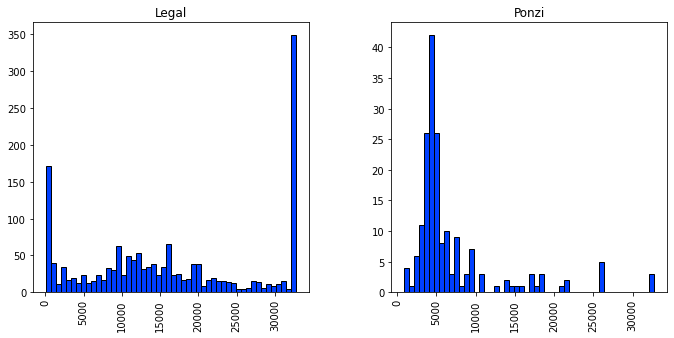

In [14]:
mpl.rcParams['patch.force_edgecolor'] = True
plt.style.use('seaborn-bright')
data_filtered.hist(column='length', by='Type', bins=50,figsize=(11,5))

In [15]:
text_feat = data_filtered['opcodes'].copy()

In [16]:
def text_process(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    #text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    #TODO:implement stopwords list for some special cases
    text = [word for word in text.split()]
    return " ".join(text)

In [17]:
text_feat = text_feat.apply(text_process)

In [32]:
# Ngrams=3
vectorizer = TfidfVectorizer(tokenizer=str.split, ngram_range=(1, 3))
features = vectorizer.fit_transform(text_feat)
data_filtered = data_filtered.dropna(subset=['Type'])
features = vectorizer.fit_transform(data_filtered['opcodes'])

features_train, features_test, labels_train, labels_test = train_test_split(
    features, 
    data_filtered['Type'], 
    test_size=0.3, 
    random_state=111, 
    stratify=data_filtered['Type']
)

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=62, random_state=111)
bc = BaggingClassifier(n_estimators=9, random_state=111)
etc = ExtraTreesClassifier(n_estimators=9, random_state=111)

In [34]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc}


In [35]:
def train_classifier(clf, feature_train, labels_train):    
    clf.fit(feature_train, labels_train)
def predict_labels(clf, features):
    return (clf.predict(features))

In [36]:

from sklearn.metrics.pairwise import cosine_similarity

# Compute the centroid vector for each class in the training data
class_centroids = {}
unique_labels = np.unique(labels_train)
for label in unique_labels:
    centroid = features_train[labels_train == label].mean(axis=0)
    # Convert centroid to numpy array (if it's not already)
    class_centroids[label] = np.asarray(centroid).reshape(1, -1)  # Ensure it's a 2D array

    
# Compute cosine similarity between each document and each class centroid
similarity_features_train = np.hstack([cosine_similarity(features_train, class_centroids[label]) for label in unique_labels])
similarity_features_test = np.hstack([cosine_similarity(features_test, class_centroids[label]) for label in unique_labels])
# Use these similarity scores as additional features
features_train_extended = np.hstack((features_train.toarray(), similarity_features_train))
features_test_extended = np.hstack((features_test.toarray(), similarity_features_test))

In [37]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, accuracy_score(labels_test,pred)))


In [38]:
pred_scores

[('SVC', 0.9963302752293578),
 ('KN', 0.9798165137614679),
 ('NB', 0.9688073394495413),
 ('DT', 0.998165137614679),
 ('LR', 0.9853211009174312),
 ('RF', 0.9926605504587156),
 ('AdaBoost', 0.998165137614679),
 ('BgC', 0.9963302752293578),
 ('ETC', 0.9944954128440368)]

In [39]:
df = pd.DataFrame.from_records(pred_scores, index='', columns=[ '', 'Score'])
df

,,Score
,,
SVC,SVC,0.996330
KN,KN,0.979817
NB,NB,0.968807
DT,DT,0.998165
LR,LR,0.985321
RF,RF,0.992661
AdaBoost,AdaBoost,0.998165
BgC,BgC,0.996330
ETC,ETC,0.994495


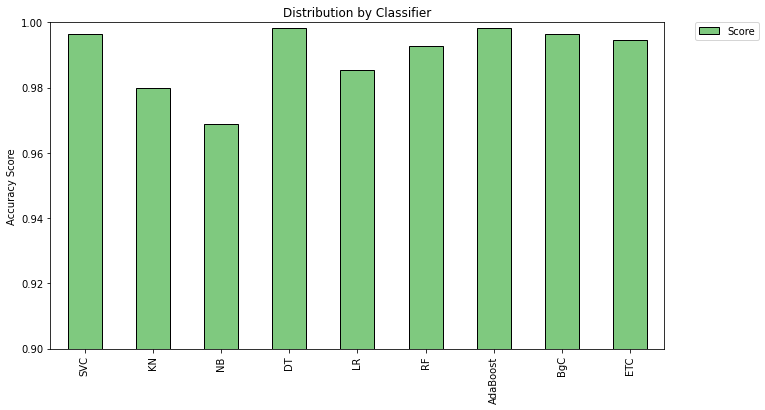

In [40]:
df.plot(kind='bar', ylim=(0.9,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [41]:
#N gram = n
vectorizer = TfidfVectorizer(tokenizer=str.split, ngram_range=(1, 2))
features = vectorizer.fit_transform(text_feat)
data_filtered = data_filtered.dropna(subset=['Type'])
features = vectorizer.fit_transform(data_filtered['opcodes'])

features_train, features_test, labels_train, labels_test = train_test_split(
    features, 
    data_filtered['Type'], 
    test_size=0.3, 
    random_state=111, 
    stratify=data_filtered['Type']
)
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, accuracy_score(labels_test,pred)))
pred_scores

In [46]:
df = pd.DataFrame.from_records(pred_scores, index='', columns=[ '', 'Score'])
df

,,Score
,,
SVC,SVC,0.988991
KN,KN,0.977982
NB,NB,0.954128
DT,DT,0.996330
LR,LR,0.985321
RF,RF,0.994495
AdaBoost,AdaBoost,0.998165
BgC,BgC,0.996330
ETC,ETC,0.990826


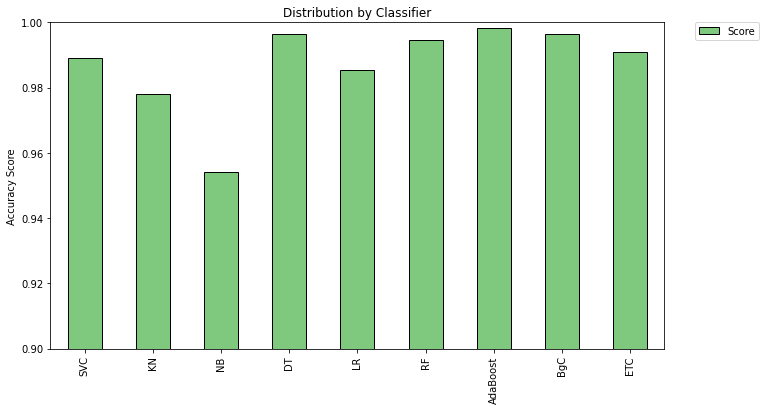

In [47]:
df.plot(kind='bar', ylim=(0.9,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [50]:
# N-gram = 5
vectorizer = TfidfVectorizer(tokenizer=str.split, ngram_range=(1, 5))
features = vectorizer.fit_transform(text_feat)
data_filtered = data_filtered.dropna(subset=['Type'])
features = vectorizer.fit_transform(data_filtered['opcodes'])

features_train, features_test, labels_train, labels_test = train_test_split(
    features, 
    data_filtered['Type'], 
    test_size=0.3, 
    random_state=111, 
    stratify=data_filtered['Type']
)
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, accuracy_score(labels_test,pred)))
pred_scores

[('SVC', 0.9963302752293578),
 ('KN', 0.9761467889908257),
 ('NB', 0.9743119266055046),
 ('DT', 0.9963302752293578),
 ('LR', 0.9834862385321101),
 ('RF', 0.9908256880733946),
 ('AdaBoost', 0.9963302752293578),
 ('BgC', 0.9963302752293578),
 ('ETC', 0.9944954128440368)]

In [51]:
df = pd.DataFrame.from_records(pred_scores, index='', columns=[ '', 'Score'])
df

,,Score
,,
SVC,SVC,0.996330
KN,KN,0.976147
NB,NB,0.974312
DT,DT,0.996330
LR,LR,0.983486
RF,RF,0.990826
AdaBoost,AdaBoost,0.996330
BgC,BgC,0.996330
ETC,ETC,0.994495


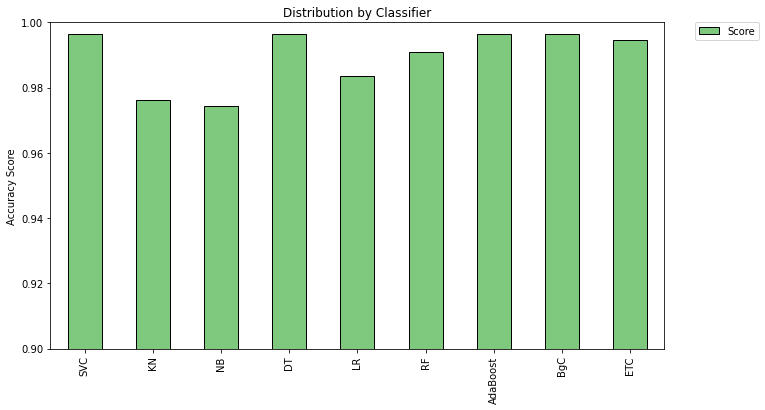

In [52]:
df.plot(kind='bar', ylim=(0.9,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [53]:
# N-gram = 7
vectorizer = TfidfVectorizer(tokenizer=str.split, ngram_range=(1, 7))
features = vectorizer.fit_transform(text_feat)
data_filtered = data_filtered.dropna(subset=['Type'])
features = vectorizer.fit_transform(data_filtered['opcodes'])

features_train, features_test, labels_train, labels_test = train_test_split(
    features, 
    data_filtered['Type'], 
    test_size=0.3, 
    random_state=111, 
    stratify=data_filtered['Type']
)
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, accuracy_score(labels_test,pred)))
pred_scores

[('SVC', 0.9963302752293578),
 ('KN', 0.9779816513761468),
 ('NB', 0.9761467889908257),
 ('DT', 0.9944954128440368),
 ('LR', 0.981651376146789),
 ('RF', 0.9908256880733946),
 ('AdaBoost', 0.9963302752293578),
 ('BgC', 0.9944954128440368),
 ('ETC', 0.9944954128440368)]